## Import Modules

In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt

from lmfit import models


## Code Analyse Data

##### Berekeningen Foton flux en Elektronen stroom uit data

In [2]:
# Gemeten lichtintensiteit per cm**2
# data_licht = [Blauw, Groen, Rood, IR] voor alle sets.
#--------------------------------------------------- < Meting Test 1> ---------------------------------------------
data_spectrometer_1 = [46.7*10**(-2), 70.5*10**(-2), 129.8*10**(-2), 1241*10**(-2)] #[Watt/m**2]
data_golflengtes_1 = [410*10**(-9), 560*10**(-9), 650*10**(-9), 840*10**(-9)] #[m]
data_voltage_1 = [4.1*10**(-3), 25.1*10**(-3), 52.4*10**(-3), 193.5*10**(-3)] #[V]
data_amperage_1 = [0.62*10**(-3), 3.72*10**(-3), 7.8*10**(-3), 28.45*10**(-3)] #[A]

# Natuur constantes:
    # Waarde van Wikipedia
planck_constante = 6.62607015 * 10**(-34) #[J*s]
    # Waarde van Wikipedia
lichtsnelheid = 299792458 #[m/s]
    # Waarde van Wikipedia
elektron_energie = 1.602176565 * 10**(-19) #[J]


# Berekenen fotonflux uit spectrometer.
def foton_flux_energie(golflengte, input_vermogen_spectrometer):

    lijst_foton_energie = []
    for i in golflengte:
        foton_energie = (planck_constante * lichtsnelheid) / i
        lijst_foton_energie.append(foton_energie)

    return lijst_foton_energie


def foton_flux(golflengte, input_vermogen_spectrometer):

    lijst_foton_energie = []
    for i in golflengte:
        foton_energie = (planck_constante * lichtsnelheid) / i
        lijst_foton_energie.append(foton_energie)

    teller = 0
    lijst_foton_flux = []
    for j in input_vermogen_spectrometer:

        flux = j / lijst_foton_energie[teller] #[Aantal fotonen/cm(**2) * s]
        lijst_foton_flux.append(flux)
        teller += 1

    return lijst_foton_flux, lijst_foton_energie


# Geeft een lijst
def elektronen_stroom(voltage, amperage): 

    lijst_vermogen_e = []
    teller = 0

    for i in voltage:

        vermogen_e = i * amperage[teller]

        lijst_vermogen_e.append(vermogen_e)
        teller += 1

    lijst_flux_e = []
    for j in lijst_vermogen_e:
        flux = j / elektron_energie #[Aantal elektronen/s]
        lijst_flux_e.append(flux)

    return lijst_flux_e

print(elektronen_stroom(data_voltage_1, data_amperage_1))

def quantum_efficiency(foton_flux, elektronen_flux, oppervlak):

    lijst_QE = []
    teller = 0

    for i in foton_flux:
        
        qe = (elektronen_flux[teller]) / (i * oppervlak)  
        
        lijst_QE.append(qe)
        teller += 1 

    return lijst_QE

print(quantum_efficiency(foton_flux(data_golflengtes_1, data_spectrometer_1)[0], elektronen_stroom(data_voltage_1, data_amperage_1), 25))

[15865916750567.375, 582782210398889.6, 2551029698777301.0, 3.4359977047848036e+16]
[6.584171849174146e-07, 1.172913178791256e-05, 2.40250438620365e-05, 2.6190182287107174e-05]


##### Fouten propogatie

In [3]:
# Foutenpropagatie foton flux.
def fout_flux_foton(foton_energie, input_vermogen_spectrometer):

    lijst_error_input_vermogen_spectrometer = []
    for i in input_vermogen_spectrometer:

        error_input_vermogen_spectrometer = 0.01 * i
        lijst_error_input_vermogen_spectrometer.append(error_input_vermogen_spectrometer)

    teller = 0
    lijst_fouten_fotonen = []

    for j in foton_energie:

        fout_fotonen = np.sqrt(((1/j)*lijst_error_input_vermogen_spectrometer[teller])**2)
        lijst_fouten_fotonen.append(fout_fotonen)
        teller += 1

    return lijst_fouten_fotonen    


# Foutenpropagatie elektronen flux.
def fout_flux_elektron(voltage, amperage):

    lijst_error_volt = []
    for i in voltage:

        error_voltage = (0.008 * i) + 0.0001
        lijst_error_volt.append(error_voltage)


    lijst_error_ampere = []
    for j in amperage:

        error_amperage = (0.013 * j) + 0.0000001
        lijst_error_ampere.append(error_amperage)


    lijst_fout_elektronen = []
    teller = 0

    for k in lijst_error_volt:

        fout_elektronen = np.sqrt(((amperage[teller]/elektron_energie)*k)**2 + ((voltage[teller]/elektron_energie)*lijst_error_ampere[0])**2)
        lijst_fout_elektronen.append(fout_elektronen)
        teller += 1

    return lijst_fout_elektronen


# Foutenpropagatie QE.

def fout_QE (foton_flux, oppervlak, elektronen_stroom, fout_fotonen, fout_elektronen): # Input lijsten

    fout_oppervlak = 0.001      # [m] Hier rond de 1mm door meetlat gebruikt. 
    lengte = np.sqrt(oppervlak)

    lijst_fout_1 = []
    teller = 0
    for i in foton_flux:

        fout_1 = ((-elektronen_stroom[teller]) / (oppervlak * (i)**2)) * fout_fotonen[teller]
        lijst_fout_1.append(fout_1)
        teller += 1

    lijst_fout_2 = []
    teller = 0
    for j in foton_flux:

        fout_2 = (1/(oppervlak * j)) * fout_elektronen[teller]
        lijst_fout_2.append(fout_2)
        teller += 1

    lijst_fout_3 = []
    teller = 0
    for k in foton_flux:

        fout_3 = (-elektronen_stroom[teller]) / (((oppervlak**2 * k))) * 2*lengte*fout_oppervlak
        lijst_fout_3.append(fout_3)
        teller += 1
    #print (lijst_fout_3)

    lijst_fout_QE = []
    teller = 0
    for p in lijst_fout_1:
        
        fout_qe = np.sqrt((p)**2 + (lijst_fout_2[teller])**2 + (lijst_fout_3[teller])**2)
        lijst_fout_QE.append(fout_qe)
        teller += 1
    
    return lijst_fout_QE

    

##### Uitwerken meting 1

Deze meting is verworpen


In [4]:
# #print(foton_flux(data_golflengtes_1, data_spectrometer_1)[1])

# #print(elektronen_stroom(data_voltage_1, data_amperage_1))

# oppervlak = float(25) #cm**2
# print(quantum_efficiency(foton_flux(data_golflengtes_1, data_spectrometer_1)[0], elektronen_stroom(data_voltage_1, data_amperage_1), oppervlak))

# fout_QE(foton_flux(data_golflengtes_1, data_spectrometer_1)[0], oppervlak, elektronen_stroom(data_voltage_1, data_amperage_1), fout_flux_foton(foton_flux_energie(data_golflengtes_1, data_spectrometer_1), data_spectrometer_1), fout_flux_elektron(data_voltage_1, data_amperage_1))



##### Uitwerking meting 2


In [5]:
#data_licht = [Blauw, Blauw, Blauw, Groen, Groen, Groen, Rood, Rood, Rood, IR, IR, IR,] voor alle sets.

data_golflengtes_2 = [410*10**(-9), 430*10**(-9), 450*10**(-9), 510*10**(-9), 560*10**(-9), 580*10**(-9), 625*10**(-9), 650*10**(-9), 680*10**(-9), 805*10**(-9), 840*10**(-9), 890*10**(-9)]   	        # meter
data_spectrometer_2 = [99.8*10**(-2), 83.7*10**(-2), 73.8*10**(-2), 762*10**(-2), 653*10**(-2), 663*10**(-2), 1362*10**(-2), 1288*10**(-2), 1248*10**(-2), 13140*10**(-2), 11010*10**(-2), 8760*10**(-2)]   # Watt/(m**2) s**(-1)
data_voltage_2 = [2.2*10**(-3), 2.2*10**(-3), 2.2*10**(-3), 17.9*10**(-3), 17.9*10**(-3), 17.9*10**(-3), 38.8*10**(-3), 38.8*10**(-3), 38.8*10**(-3), 129.4*10**(-3), 129.4*10**(-3), 129.4*10**(-3)]       # Volt
data_amperage_2 = [0.38*10**(-3), 0.38*10**(-3), 0.38*10**(-3), 3.06*10**(-3), 3.06*10**(-3), 3.06*10**(-3), 6.67*10**(-3), 6.67*10**(-3), 6.67*10**(-3), 22.14*10**(-3), 22.14*10**(-3), 22.14*10**(-3)]   # Ampère

oppervlak = float(25*10**(-4)) #m**2

#quantum_efficiency(foton_flux(data_golflengtes_2, data_spectrometer_2)[0], elektronen_stroom(data_voltage_2, data_amperage_2), oppervlak)
# print(quantum_efficiency(foton_flux(data_golflengtes_2, data_spectrometer_2)[0], elektronen_stroom(data_voltage_2, data_amperage_2), oppervlak))
print(fout_QE(foton_flux(data_golflengtes_2, data_spectrometer_2)[0], oppervlak, elektronen_stroom(data_voltage_2, data_amperage_2), fout_flux_foton(foton_flux_energie(data_golflengtes_2, data_spectrometer_2), data_spectrometer_2), fout_flux_elektron(data_voltage_2, data_amperage_2)))










[np.float64(6.971082684138686e-05), np.float64(7.925391383112078e-05), np.float64(8.589062368852356e-05), np.float64(0.00030366663882245404), np.float64(0.0003227163891358074), np.float64(0.00030688856602481427), np.float64(0.0006418889196843641), np.float64(0.0006526611835658326), np.float64(0.000643863054865803), np.float64(0.0005662293747518047), np.float64(0.0006476152045015532), np.float64(0.0007682269325986564)]


### Plot na meting twee


[np.float64(0.006971082684138686), np.float64(0.007925391383112079), np.float64(0.008589062368852356), np.float64(0.030366663882245404), np.float64(0.032271638913580744), np.float64(0.030688856602481426), np.float64(0.06418889196843641), np.float64(0.06526611835658326), np.float64(0.06438630548658031), np.float64(0.05662293747518047), np.float64(0.06476152045015532), np.float64(0.07682269325986564)]


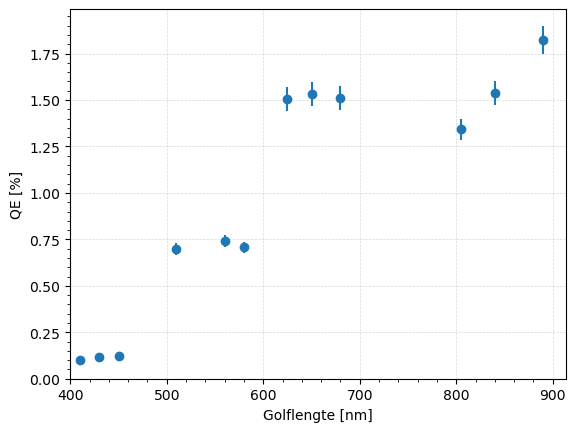

In [6]:

# Waarde omzetten van meter naar nano meters voor netheid in grafiek
x = []
for n in data_golflengtes_2:
    item = n * 10**(9)
    x.append(item)

QE_data = quantum_efficiency(foton_flux(data_golflengtes_2, data_spectrometer_2)[0], elektronen_stroom(data_voltage_2, data_amperage_2), oppervlak)

# Waarde omzetten naar QE in percentages voor netheid grafiek.
y = []
for m in QE_data:
    item = m * 100
    y.append(item)

# Waarde omzetten naar QE in percentages.
yerr_meter = fout_QE(foton_flux(data_golflengtes_2, data_spectrometer_2)[0], oppervlak, elektronen_stroom(data_voltage_2, data_amperage_2), fout_flux_foton(foton_flux_energie(data_golflengtes_2, data_spectrometer_2), data_spectrometer_2), fout_flux_elektron(data_voltage_2, data_amperage_2))
# print(yerr_meter)
# print(y)
yerr = []
for k in yerr_meter:
    item = k * 100
    yerr.append(item)

print (yerr)



fig_QE_golflengte = plt.figure("Meting 2")

plt.errorbar(x, y, yerr, fmt='o')
plt.xlabel("Golflengte [nm]")
plt.ylabel("QE [%]")
# Change the x and y ticks by adding minor ticks
plt.minorticks_on()
plt.tick_params(which='minor', length=2)
plt.grid(linestyle = '--', linewidth = 0.5, alpha = 0.5)
plt.xlim(400)
plt.ylim(0)
plt.savefig("plot_versie_1")